In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import gc
import time
import subprocess
from concurrent.futures import ProcessPoolExecutor, as_completed

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, Draw
from rdkit import RDConfig
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, rdDistGeom, rdPartialCharges
from rdkit.Chem.AllChem import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json

2024-10-22 16:15:47.353235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 16:15:47.410527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 16:15:47.428538: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 16:15:47.516235: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 16:15:48.857768: W tensorflow/compiler/tf2

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error,mean_squared_error

In [5]:
tf.keras.backend.clear_session()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

I0000 00:00:1729581352.212913   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581352.391711   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581352.391825   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [6]:
target_path = "result/2_solubility_fingerprint_compare"
os.makedirs(target_path, exist_ok=True)

In [7]:
data_ws = pd.read_csv('./data/ws496_logS.csv', dtype={'SMILES': 'string'})
smiles_ws = data_ws['SMILES']
y_ws = data_ws.iloc[:, 2]

data_delaney = pd.read_csv('./data/delaney-processed.csv', dtype={'smiles': 'string'})
smiles_de = data_delaney['smiles']
y_de = data_delaney.iloc[:, 1]

data_lovric2020 = pd.read_csv('./data/Lovric2020_logS0.csv', dtype={'isomeric_smiles': 'string'})
smiles_lo = data_lovric2020['isomeric_smiles']
y_lo = data_lovric2020.iloc[:, 1]

data_huuskonen = pd.read_csv('./data/huusk.csv', dtype={'SMILES': 'string'})
smiles_hu = data_huuskonen['SMILES']
y_hu = data_huuskonen.iloc[:, -1].astype('float')

In [8]:
def mol3d(mol):
    mol = Chem.AddHs(mol)
    optimization_methods = [
        (AllChem.EmbedMolecule, (mol, AllChem.ETKDGv3()), {}),
        (AllChem.UFFOptimizeMolecule, (mol,), {'maxIters': 200}),
        (AllChem.MMFFOptimizeMolecule, (mol,), {'maxIters': 200})
    ]

    for method, args, kwargs in optimization_methods:
        try:
            method(*args, **kwargs)
            if mol.GetNumConformers() > 0:
                return mol
        except ValueError as e:
            print(f"Error: {e} - Trying next optimization method [{method}]")

    print(f"Invalid mol for 3d {'\033[94m'}{Chem.MolToSmiles(mol)}{'\033[0m'} - No conformer generated")
    return None

In [9]:
def convert_smiles_to_mol(smiles, fail_folder=None, index=None, yvalue=None):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"[convert_smiles_to_mol] Cannot convert {smiles} to Mols")
        return None, {"smiles": smiles, "y_value": yvalue, "error": "Invalid SMILES"}

    try:
        Chem.Kekulize(mol, clearAromaticFlags=True)
        isomeric_smiles = Chem.MolToSmiles(mol, isomericSmiles=True)
        mol = Chem.MolFromSmiles(isomeric_smiles)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} isomeric_smiles by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"Isomeric SMILES error: {e}"}

    try:
        Chem.SanitizeMol(mol)
    except Exception as e:
        print(f"[convert_smiles_to_mol] failed {smiles} SanitizeMol by {e}")
        if fail_folder and index is not None:
            img_path = os.path.join(fail_folder, f"mol_{index}.png")
            img = Draw.MolToImage(mol)
            img.save(img_path)
        return None, {"smiles": smiles, "y_value": yvalue, "error": f"SanitizeMol error: {e}"}

    return mol, None

In [10]:
def process_smiles(smiles, yvalue, fail_folder, index):
    mol, error = convert_smiles_to_mol(smiles, fail_folder, index, yvalue)
    if error:
        return None, None, error

    mol_3d = mol3d(mol)
    if mol_3d:
        return smiles, yvalue, None
    else:
        img_path = os.path.join(fail_folder, f"mol_{index}.png")
        img = Draw.MolToImage(mol)
        img.save(img_path)
        return None, None, {"smiles": smiles, "y_value": yvalue}

def process_dataset(smiles_list, y_values, dataset_name, target_path="result", max_workers=None):
    start = time.time()
    valid_smiles, valid_y = [], []
    error_smiles_list = []
    fail_folder = f"{target_path}/failed/{dataset_name}"
    os.makedirs(fail_folder, exist_ok=True)

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [
            executor.submit(process_smiles, smiles, yvalue, fail_folder, i)
            for i, (smiles, yvalue) in enumerate(zip(smiles_list, y_values))
        ]
        for future in as_completed(futures):
            smiles, yvalue, error = future.result()
            if error:
                error_smiles_list.append(error)
            elif smiles is not None and yvalue is not None:
                valid_smiles.append(smiles)
                valid_y.append(yvalue)

    if error_smiles_list:
        error_df = pd.DataFrame(error_smiles_list)
        error_df.to_csv(os.path.join(fail_folder, "failed_smiles.csv"), index=False)
    print(f" [{dataset_name:<10}] : {time.time()-start:.4f} sec")
    return valid_smiles, valid_y

In [11]:
smiles_ws, y_ws = process_dataset(smiles_ws, y_ws, "ws496", target_path)
smiles_de, y_de = process_dataset(smiles_de, y_de, "delaney", target_path)
smiles_lo, y_lo = process_dataset(smiles_lo, y_lo, "Lovric2020_logS0", target_path)
smiles_hu, y_hu = process_dataset(smiles_hu, y_hu, "huusk", target_path)

 [ws496     ] : 0.9100 sec
 [delaney   ] : 1.5038 sec
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x5578a56c9760>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x5578a56ca5f0>]
Invalid mol for 3d [H]O[C@]([H])(c1c([H])c([H])nc2c([H])c([H])c(OC([H])([H])[H])c([H])c12)[C@@]1([H])[N@]2C([H])([H])C([H])([H])[C@@]([H])(C1([H])[H])[C@@]([H])(C([H])=C([H])[H])C2([H])[H] - No conformer generated
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x5578a56c9760>]
Error: Bad Conformer Id - Trying next optimization method [<Boost.Python.function object at 0x5578a56ca5f0>]
Invalid mol for 3d [H]O[C@@]([H])(c1c([H])c([H])nc2c([H])c([H])c(OC([H])([H])[H])c([H])c12)[C@]1([H])[N@]2C([H])([H])C([H])([H])[C@@]([H])(C1([H])[H])[C@@]([H])(C([H])=C([H])[H])C2([H])[H] - No conformer generated
 [Lovric2020_logS0] : 9.3446 sec
 [huusk     ] : -0.2241 sec


In [12]:
LEN_OF_FF = 2048
LEN_OF_MA = 167
LEN_OF_AV = 512

In [13]:
def get_fingerprints(mol):
    if mol is None:
        return None, None, None
    
    morgan_generator = GetMorganGenerator(radius=2, fpSize=LEN_OF_FF)
    ecfp = morgan_generator.GetFingerprint(mol)
    ecfp_array = np.zeros((LEN_OF_FF,),dtype=int)
    DataStructs.ConvertToNumpyArray(ecfp, ecfp_array)
    
    maccs = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)

    avalon_fp = GetAvalonFP(mol)
    avalon_array = np.zeros((LEN_OF_AV,),dtype=int)
    DataStructs.ConvertToNumpyArray(avalon_fp, avalon_array)
    
    return ecfp_array, maccs, avalon_array

def fp_converter(data, use_parallel=True):
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    if use_parallel:
        try:            
            with ProcessPoolExecutor() as executor:
                results = list(executor.map(get_fingerprints, mols))
        except Exception as e:
            print(f"Parallel processing failed due to: {e}. Falling back to sequential processing.")
            use_parallel = False
    
    if not use_parallel:
        results = [get_fingerprints(mol) for mol in mols]
    
    ECFP, MACCS, AvalonFP = zip(*results)
    
    ECFP_container = np.vstack([arr for arr in ECFP if arr is not None])
    MACCS_container = np.zeros((len(MACCS), LEN_OF_MA), dtype=int)
    AvalonFP_container = np.vstack([arr for arr in AvalonFP if arr is not None])

    for i, fp in enumerate(MACCS):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, MACCS_container[i])
    
    return mols, ECFP_container, MACCS_container, AvalonFP_container

In [14]:
mol_ws, x_ws, MACCS_ws, AvalonFP_ws = fp_converter(smiles_ws)
mol_de, x_de, MACCS_de, AvalonFP_de = fp_converter(smiles_de)
mol_lo, x_lo, MACCS_lo, AvalonFP_lo = fp_converter(smiles_lo)
mol_hu, x_hu, MACCS_hu, AvalonFP_hu = fp_converter(smiles_hu)

In [15]:
#Morgan Fingerprint (ECFP)
xtr_ws1, xte_ws1, ytr_ws1, yte_ws1 = train_test_split(x_ws, y_ws, test_size=0.2,random_state=42)
xtr_de1, xte_de1, ytr_de1, yte_de1 = train_test_split(x_de, y_de, test_size=0.2,random_state=42)
xtr_lo1, xte_lo1, ytr_lo1, yte_lo1 = train_test_split(x_lo, y_lo, test_size=0.2,random_state=42)
xtr_hu1, xte_hu1, ytr_hu1, yte_hu1 = train_test_split(x_hu, y_hu, test_size=0.2,random_state=42)

In [16]:
#MACCS Fingerprint
xtr_ws2, xte_ws2, ytr_ws2, yte_ws2 = train_test_split(MACCS_ws, y_ws, test_size=0.2,random_state=42)
xtr_de2, xte_de2, ytr_de2, yte_de2 = train_test_split(MACCS_de, y_de, test_size=0.2,random_state=42)
xtr_lo2, xte_lo2, ytr_lo2, yte_lo2 = train_test_split(MACCS_lo, y_lo, test_size=0.2,random_state=42)
xtr_hu2, xte_hu2, ytr_hu2, yte_hu2 = train_test_split(MACCS_hu, y_hu, test_size=0.2,random_state=42)

In [17]:
#Avalon Fingerprint
xtr_ws3, xte_ws3, ytr_ws3, yte_ws3 = train_test_split(AvalonFP_ws, y_ws, test_size=0.2,random_state=42)
xtr_de3, xte_de3, ytr_de3, yte_de3 = train_test_split(AvalonFP_de, y_de, test_size=0.2,random_state=42)
xtr_lo3, xte_lo3, ytr_lo3, yte_lo3 = train_test_split(AvalonFP_lo, y_lo, test_size=0.2,random_state=42)
xtr_hu3, xte_hu3, ytr_hu3, yte_hu3 = train_test_split(AvalonFP_hu, y_hu, test_size=0.2,random_state=42)

In [18]:
def concatenate_to_numpy(*dataframes):
    numpy_arrays = [df.to_numpy() if isinstance(df, pd.DataFrame) else df for df in dataframes]
    if not all(isinstance(arr, np.ndarray) for arr in numpy_arrays):
        raise ValueError("All inputs must be either pandas DataFrame or numpy array")
    return np.concatenate(numpy_arrays, axis=1)

In [19]:
#ECFP + MACCS
group_nws1 = concatenate_to_numpy(x_ws, MACCS_ws)
group_nde1 = concatenate_to_numpy(x_de, MACCS_de)
group_nlo1 = concatenate_to_numpy(x_lo, MACCS_lo)
group_nhu1 = concatenate_to_numpy(x_hu, MACCS_hu)

xtr_ws12, xte_ws12, ytr_ws12, yte_ws12 = train_test_split(group_nws1, y_ws, test_size=0.2,random_state=42)
xtr_de12, xte_de12, ytr_de12, yte_de12 = train_test_split(group_nde1, y_de, test_size=0.2,random_state=42)
xtr_lo12, xte_lo12, ytr_lo12, yte_lo12 = train_test_split(group_nlo1, y_lo, test_size=0.2,random_state=42)
xtr_hu12, xte_hu12, ytr_hu12, yte_hu12 = train_test_split(group_nhu1, y_hu, test_size=0.2,random_state=42)

In [20]:
#ECFP + Avalon
group_nws2 = concatenate_to_numpy(x_ws, AvalonFP_ws)
group_nde2 = concatenate_to_numpy(x_de, AvalonFP_de)
group_nlo2 = concatenate_to_numpy(x_lo, AvalonFP_lo)
group_nhu2 = concatenate_to_numpy(x_hu, AvalonFP_hu)

xtr_ws13, xte_ws13, ytr_ws13, yte_ws13 = train_test_split(group_nws2, y_ws, test_size=0.2,random_state=42)
xtr_de13, xte_de13, ytr_de13, yte_de13 = train_test_split(group_nde2, y_de, test_size=0.2,random_state=42)
xtr_lo13, xte_lo13, ytr_lo13, yte_lo13 = train_test_split(group_nlo2, y_lo, test_size=0.2,random_state=42)
xtr_hu13, xte_hu13, ytr_hu13, yte_hu13 = train_test_split(group_nhu2, y_hu, test_size=0.2,random_state=42)

In [21]:
#MACCS + Avalon
group_nws3 = concatenate_to_numpy(MACCS_ws, AvalonFP_ws)
group_nde3 = concatenate_to_numpy(MACCS_de, AvalonFP_de)
group_nlo3 = concatenate_to_numpy(MACCS_lo, AvalonFP_lo)
group_nhu3 = concatenate_to_numpy(MACCS_hu, AvalonFP_hu)

xtr_ws23, xte_ws23, ytr_ws23, yte_ws23 = train_test_split(group_nws3, y_ws, test_size=0.2,random_state=42)
xtr_de23, xte_de23, ytr_de23, yte_de23 = train_test_split(group_nde3, y_de, test_size=0.2,random_state=42)
xtr_lo23, xte_lo23, ytr_lo23, yte_lo23 = train_test_split(group_nlo3, y_lo, test_size=0.2,random_state=42)
xtr_hu23, xte_hu23, ytr_hu23, yte_hu23 = train_test_split(group_nhu3, y_hu, test_size=0.2,random_state=42)

In [22]:
#ECFP + MACCS + Avalon
fgroup_nws = concatenate_to_numpy(x_ws, MACCS_ws, AvalonFP_ws)
fgroup_nde = concatenate_to_numpy(x_de, MACCS_de, AvalonFP_de)
fgroup_nlo = concatenate_to_numpy(x_lo, MACCS_lo, AvalonFP_lo)
fgroup_nhu = concatenate_to_numpy(x_hu, MACCS_hu, AvalonFP_hu)

xtr_wsf, xte_wsf, ytr_wsf, yte_wsf = train_test_split(fgroup_nws, y_ws, test_size=0.2,random_state=42)
xtr_def, xte_def, ytr_def, yte_def = train_test_split(fgroup_nde, y_de, test_size=0.2,random_state=42)
xtr_lof, xte_lof, ytr_lof, yte_lof = train_test_split(fgroup_nlo, y_lo, test_size=0.2,random_state=42)
xtr_huf, xte_huf, ytr_huf, yte_huf = train_test_split(fgroup_nhu, y_hu, test_size=0.2,random_state=42)

In [23]:
BATCHSIZE = 32
EPOCHS = 100
lr = 0.0001
decay = 1e-4

In [24]:
def new_inference_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            units=1024,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(decay)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(
            units=469,
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(decay)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=1)
    ])
    
    return model

def save_model():
    model = new_inference_model()
    model_json = model.to_json()
    os.makedirs("save_model", exist_ok=True)  # Ensure the directory exists
    with open("save_model/model_config.json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights("save_model/model_weights.weights.h5")

In [25]:
# Environment settings for optimal performance
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 --tf_xla_enable_xla_devices'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda --xla_gpu_force_compilation_parallelism=1'

import logging
class FilterNUMA(logging.Filter):
    def filter(self, record):
        return "NUMA" not in record.getMessage() and "XLA service" not in record.getMessage()

logger = logging.getLogger()
logger.setLevel(logging.ERROR)
for handler in logger.handlers:
    handler.addFilter(FilterNUMA())

In [26]:
import re
import subprocess
from tensorflow.keras.models import load_model

In [27]:
def model_study_datasets(xtr_list, ytr_list):
    models = []
    
    fps_file = 'new_fps.npy'
    y_true_file = 'y_true.npy'
    
    for i in range(len(xtr_list)):
        np.save(fps_file, xtr_list[i])
        np.save(y_true_file, ytr_list[i])
        
        save_model()
        
        result = subprocess.run(['python3', './extra_code/basic_model.py', 
                                 str(BATCHSIZE), str(EPOCHS),
                                 fps_file, y_true_file],
                                stdout=subprocess.PIPE, 
                                stderr=subprocess.PIPE, 
                                text=True)
    
        if result.stderr:
            sys.stderr.write(result.stderr)
        
        warning_patterns = [
            r'WARNING: All log messages before absl::InitializeLog\(\) is called are written to STDERR',
            r'could not open file to read NUMA node',
            r'Your kernel may have been built without NUMA support',
            r'XLA service .* initialized for platform (CUDA|Host)',
            r'StreamExecutor device \(0\):',
            r'Created device /job:localhost/replica:0/task:0/device:GPU:0',
            r'Using CUDA malloc Async allocator for GPU',
            r'Could not identify NUMA node of platform GPU',
        ]

        filtered_stderr = "\n".join([
            line for line in result.stderr.splitlines()
            if not any(re.search(pattern, line) for pattern in warning_patterns)
        ])
        
        if filtered_stderr:
            print(f"[{i}] Filtered stderr:")
            print(filtered_stderr)
        print(f"Return code: {result.returncode}")

        if result.returncode != 0 and filtered_stderr and not all('Your kernel may have been built without NUMA support' in line for line in filtered_stderr.split('\n')):
            raise ValueError(f"[{i}] Error during learning result process: {filtered_stderr}")
        
        try:
            trained_model = tf.keras.models.load_model('save_model/trained_model.keras')
            models.append(trained_model)
            print(f"Model {i+1} loaded successfully")
        except Exception as e:
            print(f"[{i}] Error loading model: {str(e)}")
            continue

    os.remove(fps_file)
    os.remove(y_true_file)
    
    return models

In [28]:
xtr_ws=[xtr_ws1, xtr_ws2, xtr_ws3, xtr_ws12, xtr_ws13, xtr_ws23, xtr_wsf]
ytr_ws=[ytr_ws1, ytr_ws2, ytr_ws3, ytr_ws12, ytr_ws13, ytr_ws23, ytr_wsf]
xte_ws=[xte_ws1, xte_ws2, xte_ws3, xte_ws12, xte_ws13, xte_ws23, xte_wsf]
yte_ws=[yte_ws1, yte_ws2, yte_ws3, yte_ws12, yte_ws13, yte_ws23, yte_wsf]
res_ws = model_study_datasets(xtr_ws,ytr_ws)
# 7m 30s

I0000 00:00:1729581366.770352   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581366.770474   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581366.770536   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581367.803838   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581367.804076   54798 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22

[0] Filtered stderr:
I0000 00:00:1729581371.519288   55311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 1 loaded successfully


I0000 00:00:1729581381.429190   57193 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581381.465417   57193 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581381.465517   57193 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581381.478905   57193 service.cc:146] XLA service 0x5651061d6120 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581381.478971   57193 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581381.614689   57285 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[1] Filtered stderr:
I0000 00:00:1729581382.245162   57304 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 2 loaded successfully


I0000 00:00:1729581390.732413   59154 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581390.772435   59154 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581390.772550   59154 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581390.785458   59154 service.cc:146] XLA service 0x5561280b68a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581390.785504   59154 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581390.945947   59239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[2] Filtered stderr:
I0000 00:00:1729581391.605462   59258 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 3 loaded successfully


I0000 00:00:1729581398.027167   61114 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581398.066263   61114 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581398.066376   61114 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581398.078319   61114 service.cc:146] XLA service 0x5599f1579260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581398.078364   61114 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581398.208097   61199 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[3] Filtered stderr:
I0000 00:00:1729581398.907187   61219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 4 loaded successfully


I0000 00:00:1729581407.645869   63069 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581407.672088   63069 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581407.672193   63069 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581407.682344   63069 service.cc:146] XLA service 0x55701f08b260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581407.682402   63069 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581407.807108   63154 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[4] Filtered stderr:
I0000 00:00:1729581408.506592   63173 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 5 loaded successfully


I0000 00:00:1729581417.297200   65029 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581417.326699   65029 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581417.326800   65029 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581417.337750   65029 service.cc:146] XLA service 0x55f599448f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581417.337820   65029 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581417.459708   65114 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[5] Filtered stderr:
I0000 00:00:1729581418.105614   65133 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 6 loaded successfully


I0000 00:00:1729581426.748701   66989 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581426.786880   66989 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581426.786985   66989 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581426.800483   66989 service.cc:146] XLA service 0x556fdfb8dde0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581426.800538   66989 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581426.938334   67076 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[6] Filtered stderr:
I0000 00:00:1729581425.793397   67096 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 7 loaded successfully


In [29]:
xtr_de=[xtr_de1, xtr_de2, xtr_de3, xtr_de12, xtr_de13, xtr_de23, xtr_def]
ytr_de=[ytr_de1, ytr_de2, ytr_de3, ytr_de12, ytr_de13, ytr_de23, ytr_def]
xte_de=[xte_de1, xte_de2, xte_de3, xte_de12, xte_de13, xte_de23, xte_def]
yte_de=[yte_de1, yte_de2, yte_de3, yte_de12, yte_de13, yte_de23, yte_def]
res_de = model_study_datasets(xtr_de,ytr_de)
#12m 43s

I0000 00:00:1729581434.838069   68946 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581434.875276   68946 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581434.875389   68946 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581434.888378   68946 service.cc:146] XLA service 0x55943402d1b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581434.888422   68946 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581435.019892   69037 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[0] Filtered stderr:
I0000 00:00:1729581435.710918   69056 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 1 loaded successfully


I0000 00:00:1729581446.100762   70915 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581446.128292   70915 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581446.128434   70915 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581446.138887   70915 service.cc:146] XLA service 0x55b646421050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581446.138957   70915 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581446.268979   71000 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[1] Filtered stderr:
I0000 00:00:1729581446.886196   71019 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 2 loaded successfully


I0000 00:00:1729581456.968881   72874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581457.008087   72874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581457.008217   72874 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581457.025988   72874 service.cc:146] XLA service 0x5588183f5a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581457.026038   72874 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581457.174270   72962 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[2] Filtered stderr:
I0000 00:00:1729581455.901401   72984 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 3 loaded successfully


I0000 00:00:1729581466.055888   74839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581466.095107   74839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581466.095223   74839 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581466.107885   74839 service.cc:146] XLA service 0x56093d71a050 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581466.107937   74839 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581466.245314   74924 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[3] Filtered stderr:
I0000 00:00:1729581466.945240   74943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 4 loaded successfully


I0000 00:00:1729581477.733994   76803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581477.762357   76803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581477.762461   76803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581477.771799   76803 service.cc:146] XLA service 0x562b4feb2f60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581477.771848   76803 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581477.902469   76894 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[4] Filtered stderr:
I0000 00:00:1729581478.622371   76914 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 5 loaded successfully


I0000 00:00:1729581487.303159   78774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581487.332123   78774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581487.332231   78774 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581487.343872   78774 service.cc:146] XLA service 0x564e0ada4eb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581487.343922   78774 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581487.482320   78859 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[5] Filtered stderr:
I0000 00:00:1729581488.142089   78878 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 6 loaded successfully
[6] Filtered stderr:
I0000 00:00:1729581499.502982   80842 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 7 loaded successfully


I0000 00:00:1729581498.448899   80732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581498.486189   80732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581498.486285   80732 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581498.500002   80732 service.cc:146] XLA service 0x5596e161b000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581498.500064   80732 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581498.649008   80823 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [30]:
xtr_lo=[xtr_lo1, xtr_lo2, xtr_lo3, xtr_lo12, xtr_lo13, xtr_lo23, xtr_lof]
ytr_lo=[ytr_lo1, ytr_lo2, ytr_lo3, ytr_lo12, ytr_lo13, ytr_lo23, ytr_lof]
xte_lo=[xte_lo1, xte_lo2, xte_lo3, xte_lo12, xte_lo13, xte_lo23, xte_lof]
yte_lo=[yte_lo1, yte_lo2, yte_lo3, yte_lo12, yte_lo13, yte_lo23, yte_lof]
res_lo = model_study_datasets(xtr_lo,ytr_lo)
#10m 9.2s

I0000 00:00:1729581510.471303   82705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581510.510176   82705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581510.510285   82705 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581510.523561   82705 service.cc:146] XLA service 0x56481dff04f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581510.523614   82705 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581510.665334   82796 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[0] Filtered stderr:
I0000 00:00:1729581511.384943   82815 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 1 loaded successfully


I0000 00:00:1729581519.214259   84670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581519.240393   84670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581519.240503   84670 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581519.250564   84670 service.cc:146] XLA service 0x55bdd6c5e3b0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581519.250608   84670 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581519.387208   84755 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[1] Filtered stderr:
I0000 00:00:1729581520.006096   84774 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 2 loaded successfully


I0000 00:00:1729581529.386217   86625 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581529.423024   86625 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581529.423130   86625 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581529.436833   86625 service.cc:146] XLA service 0x563fe18400d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581529.436872   86625 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581529.575150   86716 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[2] Filtered stderr:
I0000 00:00:1729581530.199878   86734 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 3 loaded successfully


I0000 00:00:1729581539.616280   88584 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581539.654333   88584 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581539.654467   88584 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581539.667632   88584 service.cc:146] XLA service 0x557a02649f20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581539.667674   88584 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581539.820620   88675 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[3] Filtered stderr:
I0000 00:00:1729581540.546660   88695 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 4 loaded successfully


I0000 00:00:1729581548.461017   90552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581548.494287   90552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581548.494436   90552 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581548.507492   90552 service.cc:146] XLA service 0x564a54dd0100 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581548.507533   90552 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581548.645477   90637 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[4] Filtered stderr:
I0000 00:00:1729581549.454003   90656 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 5 loaded successfully


I0000 00:00:1729581559.168176   92517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581559.195339   92517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581559.195458   92517 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581559.205123   92517 service.cc:146] XLA service 0x55f572a490c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581559.205168   92517 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581559.337704   92603 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[5] Filtered stderr:
I0000 00:00:1729581560.010274   92623 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 6 loaded successfully
[6] Filtered stderr:
I0000 00:00:1729581570.612888   94582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 7 loaded successfully


I0000 00:00:1729581569.581321   94477 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581569.623172   94477 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581569.623363   94477 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581569.636189   94477 service.cc:146] XLA service 0x56352683bf20 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581569.636257   94477 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581569.791304   94562 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [31]:
xtr_hu=[xtr_hu1, xtr_hu2, xtr_hu3, xtr_hu12, xtr_hu13, xtr_hu23, xtr_huf]
ytr_hu=[ytr_hu1, ytr_hu2, ytr_hu3, ytr_hu12, ytr_hu13, ytr_hu23, ytr_huf]
xte_hu=[xte_hu1, xte_hu2, xte_hu3, xte_hu12, xte_hu13, xte_hu23, xte_huf]
yte_hu=[yte_hu1, yte_hu2, yte_hu3, yte_hu12, yte_hu13, yte_hu23, yte_huf]
res_hu = model_study_datasets(xtr_hu,ytr_hu)
#13m 24s

I0000 00:00:1729581578.805726   96445 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581578.837320   96445 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581578.837496   96445 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581578.850697   96445 service.cc:146] XLA service 0x559baec64350 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581578.850737   96445 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581578.980532   96530 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[0] Filtered stderr:
I0000 00:00:1729581579.684161   96550 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 1 loaded successfully


I0000 00:00:1729581590.703218   98408 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581590.737480   98408 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581590.737578   98408 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581590.750895   98408 service.cc:146] XLA service 0x55f63480f590 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581590.750951   98408 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581590.881812   98499 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[1] Filtered stderr:
I0000 00:00:1729581591.501874   98518 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 2 loaded successfully


I0000 00:00:1729581602.121342  100372 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581602.158634  100372 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581602.158735  100372 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581602.172526  100372 service.cc:146] XLA service 0x5580df908f90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581602.172572  100372 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581602.319493  100457 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[2] Filtered stderr:
I0000 00:00:1729581602.990520  100476 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 3 loaded successfully


I0000 00:00:1729581611.816786  102337 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581611.857822  102337 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581611.857919  102337 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581611.871636  102337 service.cc:146] XLA service 0x560390707a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581611.871674  102337 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581612.014939  102422 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[3] Filtered stderr:
I0000 00:00:1729581612.721122  102442 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 4 loaded successfully


I0000 00:00:1729581624.182912  104306 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581624.221140  104306 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581624.221260  104306 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581624.234705  104306 service.cc:146] XLA service 0x5608e20ab080 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581624.234770  104306 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581624.376020  104391 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[4] Filtered stderr:
I0000 00:00:1729581625.109021  104410 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 5 loaded successfully


I0000 00:00:1729581636.750135  106274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581636.777522  106274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581636.777632  106274 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581636.788110  106274 service.cc:146] XLA service 0x563d092c0260 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581636.788153  106274 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581636.935448  106359 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

[5] Filtered stderr:
I0000 00:00:1729581637.611218  106378 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 6 loaded successfully
[6] Filtered stderr:
I0000 00:00:1729581647.823414  108343 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
GPU memory cleared.
Return code: 0
Model 7 loaded successfully


I0000 00:00:1729581646.740451  108239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581646.779158  108239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581646.779301  108239 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729581646.792678  108239 service.cc:146] XLA service 0x55995e02ef60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581646.792733  108239 service.cc:154]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1729581646.969233  108324 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.

In [32]:
def print_metrics(dataset, model_name, ypre,yte):
    r2 = r2_score(yte,ypre)
    mae  = mean_absolute_error(yte,ypre)
    mse  = mean_squared_error(yte,ypre)
    rmse = root_mean_squared_error(yte,ypre)
    print(f"[data : {dataset} ][model : {model_name} ] = r2 : {r2:.5f}, mae : {mae:.5f}, mse : {mse:.5f}, rmse : {rmse:.5f}")

In [33]:
print_metrics('ws','ECEP      ', res_ws[0].predict(xte_ws[0], verbose=0), yte_ws[0])
print_metrics('ws','MACCS     ', res_ws[1].predict(xte_ws[1], verbose=0), yte_ws[1])
print_metrics('ws','Avalon    ', res_ws[2].predict(xte_ws[2], verbose=0), yte_ws[2])
print_metrics('ws','ECEP_MACCS', res_ws[3].predict(xte_ws[3], verbose=0), yte_ws[3])
print_metrics('ws','ECEP_Ava. ', res_ws[4].predict(xte_ws[4], verbose=0), yte_ws[4])
print_metrics('ws','MACCS_Ava.', res_ws[5].predict(xte_ws[5], verbose=0), yte_ws[5])
print_metrics('ws','ECFP+MACCS+Ava.', res_ws[6].predict(xte_ws[6], verbose=0), yte_ws[6])

# [data : ws ][model : ECEP       ] = r2 : 0.66232, mae : 0.83593, mse : 1.10171, rmse : 1.04962
# [data : ws ][model : MACCS      ] = r2 : 0.74583, mae : 0.71737, mse : 0.82926, rmse : 0.91064
# [data : ws ][model : Avalon     ] = r2 : 0.71877, mae : 0.75613, mse : 0.91754, rmse : 0.95788
# [data : ws ][model : ECEP_MACCS ] = r2 : 0.77450, mae : 0.63215, mse : 0.73572, rmse : 0.85774
# [data : ws ][model : ECEP_Ava.  ] = r2 : 0.74313, mae : 0.67417, mse : 0.83806, rmse : 0.91546
# [data : ws ][model : MACCS_Ava. ] = r2 : 0.77575, mae : 0.65553, mse : 0.73164, rmse : 0.85536
# [data : ws ][model : ECFP+MACCS+Ava. ] = r2 : 0.78273, mae : 0.62530, mse : 0.70886, rmse : 0.84194

I0000 00:00:1729581657.662945   55205 service.cc:146] XLA service 0x7f8bf0002f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729581657.662992   55205 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-10-22 16:20:57.668163: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 16:20:57.696340: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-22 16:20:57.701263: W external/local_xla/xla/service/gpu/gemm_fusion_autotuner.cc:806] Compiling 29 configs for gemm_fusion_dot.17 on a single thread.
2024-10-22 16:20:58.163105: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 20 bytes spill stores, 20 bytes spill lo

[data : ws ][model : ECEP       ] = r2 : 0.61105, mae : 0.92837, mse : 1.38107, rmse : 1.17519
[data : ws ][model : MACCS      ] = r2 : 0.64861, mae : 0.87559, mse : 1.24771, rmse : 1.11701
[data : ws ][model : Avalon     ] = r2 : 0.70445, mae : 0.79791, mse : 1.04945, rmse : 1.02443
[data : ws ][model : ECEP_MACCS ] = r2 : 0.68874, mae : 0.82767, mse : 1.10520, rmse : 1.05129
[data : ws ][model : ECEP_Ava.  ] = r2 : 0.71958, mae : 0.75887, mse : 0.99571, rmse : 0.99785
[data : ws ][model : MACCS_Ava. ] = r2 : 0.74675, mae : 0.73342, mse : 0.89924, rmse : 0.94828
[data : ws ][model : ECFP+MACCS+Ava. ] = r2 : 0.76254, mae : 0.72435, mse : 0.84317, rmse : 0.91824


In [34]:
print_metrics('de','ECEP      ', res_de[0].predict(xte_de[0], verbose=0), yte_de[0])
print_metrics('de','MACCS     ', res_de[1].predict(xte_de[1], verbose=0), yte_de[1])
print_metrics('de','Avalon    ', res_de[2].predict(xte_de[2], verbose=0), yte_de[2])
print_metrics('de','ECEP_MACCS', res_de[3].predict(xte_de[3], verbose=0), yte_de[3])
print_metrics('de','ECEP_Ava. ', res_de[4].predict(xte_de[4], verbose=0), yte_de[4])
print_metrics('de','MACCS_Ava.', res_de[5].predict(xte_de[5], verbose=0), yte_de[5])
print_metrics('de','ECFP+MACCS+Ava.', res_de[6].predict(xte_de[6], verbose=0), yte_de[6])

# [data : de ][model : ECEP       ] = r2 : 0.83667, mae : 0.46861, mse : 0.48737, rmse : 0.69812
# [data : de ][model : MACCS      ] = r2 : 0.79751, mae : 0.49282, mse : 0.60425, rmse : 0.77734
# [data : de ][model : Avalon     ] = r2 : 0.85147, mae : 0.41674, mse : 0.44323, rmse : 0.66576
# [data : de ][model : ECEP_MACCS ] = r2 : 0.85653, mae : 0.38113, mse : 0.42812, rmse : 0.65431
# [data : de ][model : ECEP_Ava.  ] = r2 : 0.88713, mae : 0.35384, mse : 0.33680, rmse : 0.58035
# [data : de ][model : MACCS_Ava. ] = r2 : 0.88132, mae : 0.34731, mse : 0.35414, rmse : 0.59509
# [data : de ][model : ECFP+MACCS+Ava. ] = r2 : 0.88028, mae : 0.34027, mse : 0.35725, rmse : 0.59770

# [data : de ][model : ECEP       ] = r2 : 0.83681, mae : 0.48289, mse : 0.48696, rmse : 0.69783
# [data : de ][model : MACCS      ] = r2 : 0.81288, mae : 0.46656, mse : 0.55837, rmse : 0.74724
# [data : de ][model : Avalon     ] = r2 : 0.86393, mae : 0.38842, mse : 0.40602, rmse : 0.63720
# [data : de ][model : ECEP_MACCS ] = r2 : 0.86069, mae : 0.38990, mse : 0.41570, rmse : 0.64475
# [data : de ][model : ECEP_Ava.  ] = r2 : 0.86526, mae : 0.39938, mse : 0.40208, rmse : 0.63410
# [data : de ][model : MACCS_Ava. ] = r2 : 0.87254, mae : 0.36285, mse : 0.38035, rmse : 0.61673
# [data : de ][model : ECFP+MACCS+Ava. ] = r2 : 0.89274, mae : 0.32713, mse : 0.32007, rmse : 0.56575

2024-10-22 16:21:10.619072: W external/local_xla/xla/service/gpu/gemm_fusion_autotuner.cc:806] Compiling 28 configs for gemm_fusion_dot.17 on a single thread.
2024-10-22 16:21:10.993617: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 236 bytes spill stores, 236 bytes spill loads

2024-10-22 16:21:13.017899: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 8 bytes spill stores, 8 bytes spill loads



[data : de ][model : ECEP       ] = r2 : 0.73302, mae : 0.62410, mse : 0.72927, rmse : 0.85397
[data : de ][model : MACCS      ] = r2 : 0.81337, mae : 0.51370, mse : 0.50978, rmse : 0.71399
[data : de ][model : Avalon     ] = r2 : 0.81189, mae : 0.49952, mse : 0.51382, rmse : 0.71682
[data : de ][model : ECEP_MACCS ] = r2 : 0.85766, mae : 0.43006, mse : 0.38881, rmse : 0.62354
[data : de ][model : ECEP_Ava.  ] = r2 : 0.82396, mae : 0.48403, mse : 0.48087, rmse : 0.69345
[data : de ][model : MACCS_Ava. ] = r2 : 0.84670, mae : 0.44083, mse : 0.41874, rmse : 0.64710
[data : de ][model : ECFP+MACCS+Ava. ] = r2 : 0.85978, mae : 0.42124, mse : 0.38301, rmse : 0.61888


In [35]:
print_metrics('lo','ECEP      ', res_lo[0].predict(xte_lo[0], verbose=0), yte_lo[0])
print_metrics('lo','MACCS     ', res_lo[1].predict(xte_lo[1], verbose=0), yte_lo[1])
print_metrics('lo','Avalon    ', res_lo[2].predict(xte_lo[2], verbose=0), yte_lo[2])
print_metrics('lo','ECEP_MACCS', res_lo[3].predict(xte_lo[3], verbose=0), yte_lo[3])
print_metrics('lo','ECEP_Ava. ', res_lo[4].predict(xte_lo[4], verbose=0), yte_lo[4])
print_metrics('lo','MACCS_Ava.', res_lo[5].predict(xte_lo[5], verbose=0), yte_lo[5])
print_metrics('lo','ECFP+MACCS+Ava.', res_lo[6].predict(xte_lo[6], verbose=0), yte_lo[6])

# [data : lo ][model : ECEP       ] = r2 : 0.62102, mae : 0.73440, mse : 1.00307, rmse : 1.00153
# [data : lo ][model : MACCS      ] = r2 : 0.59578, mae : 0.68067, mse : 1.06987, rmse : 1.03435
# [data : lo ][model : Avalon     ] = r2 : 0.68422, mae : 0.67421, mse : 0.83580, rmse : 0.91422
# [data : lo ][model : ECEP_MACCS ] = r2 : 0.68492, mae : 0.64230, mse : 0.83395, rmse : 0.91321
# [data : lo ][model : ECEP_Ava.  ] = r2 : 0.69790, mae : 0.64407, mse : 0.79957, rmse : 0.89419
# [data : lo ][model : MACCS_Ava. ] = r2 : 0.70558, mae : 0.61507, mse : 0.77926, rmse : 0.88276
# [data : lo ][model : ECFP+MACCS+Ava. ] = r2 : 0.71277, mae : 0.62492, mse : 0.76024, rmse : 0.87192

2024-10-22 16:21:18.631787: W external/local_xla/xla/service/gpu/gemm_fusion_autotuner.cc:806] Compiling 28 configs for gemm_fusion_dot.17 on a single thread.
2024-10-22 16:21:19.005581: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 268 bytes spill stores, 268 bytes spill loads

2024-10-22 16:21:21.089454: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 12 bytes spill stores, 12 bytes spill loads



[data : lo ][model : ECEP       ] = r2 : 0.52569, mae : 0.81087, mse : 1.53130, rmse : 1.23746
[data : lo ][model : MACCS      ] = r2 : 0.59064, mae : 0.78713, mse : 1.32162, rmse : 1.14962
[data : lo ][model : Avalon     ] = r2 : 0.61865, mae : 0.76969, mse : 1.23118, rmse : 1.10958
[data : lo ][model : ECEP_MACCS ] = r2 : 0.62562, mae : 0.72673, mse : 1.20867, rmse : 1.09939
[data : lo ][model : ECEP_Ava.  ] = r2 : 0.62979, mae : 0.74040, mse : 1.19521, rmse : 1.09325
[data : lo ][model : MACCS_Ava. ] = r2 : 0.58346, mae : 0.75899, mse : 1.34479, rmse : 1.15965
[data : lo ][model : ECFP+MACCS+Ava. ] = r2 : 0.68656, mae : 0.71189, mse : 1.01192, rmse : 1.00594


In [36]:
print_metrics('hu','ECEP      ', res_hu[0].predict(xte_hu[0], verbose=0), yte_hu[0])
print_metrics('hu','MACCS     ', res_hu[1].predict(xte_hu[1], verbose=0), yte_hu[1])
print_metrics('hu','Avalon    ', res_hu[2].predict(xte_hu[2], verbose=0), yte_hu[2])
print_metrics('hu','ECEP_MACCS', res_hu[3].predict(xte_hu[3], verbose=0), yte_hu[3])
print_metrics('hu','ECEP_Ava. ', res_hu[4].predict(xte_hu[4], verbose=0), yte_hu[4])
print_metrics('hu','MACCS_Ava.', res_hu[5].predict(xte_hu[5], verbose=0), yte_hu[5])
print_metrics('hu','ECFP+MACCS+Ava.', res_hu[6].predict(xte_hu[6], verbose=0), yte_hu[6])

# [data : hu ][model : ECEP       ] = r2 : 0.74465, mae : 0.79418, mse : 1.13364, rmse : 1.06472
# [data : hu ][model : MACCS      ] = r2 : 0.81311, mae : 0.67737, mse : 0.82969, rmse : 0.91088
# [data : hu ][model : Avalon     ] = r2 : 0.83078, mae : 0.64302, mse : 0.75128, rmse : 0.86676
# [data : hu ][model : ECEP_MACCS ] = r2 : 0.84665, mae : 0.61117, mse : 0.68083, rmse : 0.82512
# [data : hu ][model : ECEP_Ava.  ] = r2 : 0.85118, mae : 0.58893, mse : 0.66071, rmse : 0.81284
# [data : hu ][model : MACCS_Ava. ] = r2 : 0.85636, mae : 0.57487, mse : 0.63769, rmse : 0.79856
# [data : hu ][model : ECFP+MACCS+Ava. ] = r2 : 0.86441, mae : 0.57482, mse : 0.60195, rmse : 0.77585

2024-10-22 16:21:26.633093: W external/local_xla/xla/service/gpu/gemm_fusion_autotuner.cc:806] Compiling 28 configs for gemm_fusion_dot.17 on a single thread.
2024-10-22 16:21:27.004492: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 252 bytes spill stores, 252 bytes spill loads

2024-10-22 16:21:29.032220: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 8 bytes spill stores, 8 bytes spill loads



[data : hu ][model : ECEP       ] = r2 : 0.79756, mae : 0.74109, mse : 0.98363, rmse : 0.99178
[data : hu ][model : MACCS      ] = r2 : 0.81545, mae : 0.70877, mse : 0.89674, rmse : 0.94696
[data : hu ][model : Avalon     ] = r2 : 0.85838, mae : 0.62720, mse : 0.68814, rmse : 0.82954
[data : hu ][model : ECEP_MACCS ] = r2 : 0.85673, mae : 0.60539, mse : 0.69614, rmse : 0.83435
[data : hu ][model : ECEP_Ava.  ] = r2 : 0.88684, mae : 0.56374, mse : 0.54984, rmse : 0.74151
[data : hu ][model : MACCS_Ava. ] = r2 : 0.88979, mae : 0.55776, mse : 0.53551, rmse : 0.73178
[data : hu ][model : ECFP+MACCS+Ava. ] = r2 : 0.89083, mae : 0.55597, mse : 0.53045, rmse : 0.72832


In [37]:
ypred_de = [res_de[0].predict(xte_de[0], verbose=0),
            res_de[1].predict(xte_de[1], verbose=0),
            res_de[2].predict(xte_de[2], verbose=0),
            res_de[3].predict(xte_de[3], verbose=0),
            res_de[4].predict(xte_de[4], verbose=0),
            res_de[5].predict(xte_de[5], verbose=0),
            res_de[6].predict(xte_de[6], verbose=0)]

In [38]:
ypred_ws = [res_ws[0].predict(xte_ws[0], verbose=0),
            res_ws[1].predict(xte_ws[1], verbose=0),
            res_ws[2].predict(xte_ws[2], verbose=0),
            res_ws[3].predict(xte_ws[3], verbose=0),
            res_ws[4].predict(xte_ws[4], verbose=0),
            res_ws[5].predict(xte_ws[5], verbose=0),
            res_ws[6].predict(xte_ws[6], verbose=0)]

ypred_de = [res_de[0].predict(xte_de[0], verbose=0),
            res_de[1].predict(xte_de[1], verbose=0),
            res_de[2].predict(xte_de[2], verbose=0),
            res_de[3].predict(xte_de[3], verbose=0),
            res_de[4].predict(xte_de[4], verbose=0),
            res_de[5].predict(xte_de[5], verbose=0),
            res_de[6].predict(xte_de[6], verbose=0)]

ypred_lo = [res_lo[0].predict(xte_lo[0], verbose=0),
            res_lo[1].predict(xte_lo[1], verbose=0),
            res_lo[2].predict(xte_lo[2], verbose=0),
            res_lo[3].predict(xte_lo[3], verbose=0),
            res_lo[4].predict(xte_lo[4], verbose=0),
            res_lo[5].predict(xte_lo[5], verbose=0),
            res_lo[6].predict(xte_lo[6], verbose=0)]

ypred_hu = [res_hu[0].predict(xte_hu[0], verbose=0),
            res_hu[1].predict(xte_hu[1], verbose=0),
            res_hu[2].predict(xte_hu[2], verbose=0),
            res_hu[3].predict(xte_hu[3], verbose=0),
            res_hu[4].predict(xte_hu[4], verbose=0),
            res_hu[5].predict(xte_hu[5], verbose=0),
            res_hu[6].predict(xte_hu[6], verbose=0)]

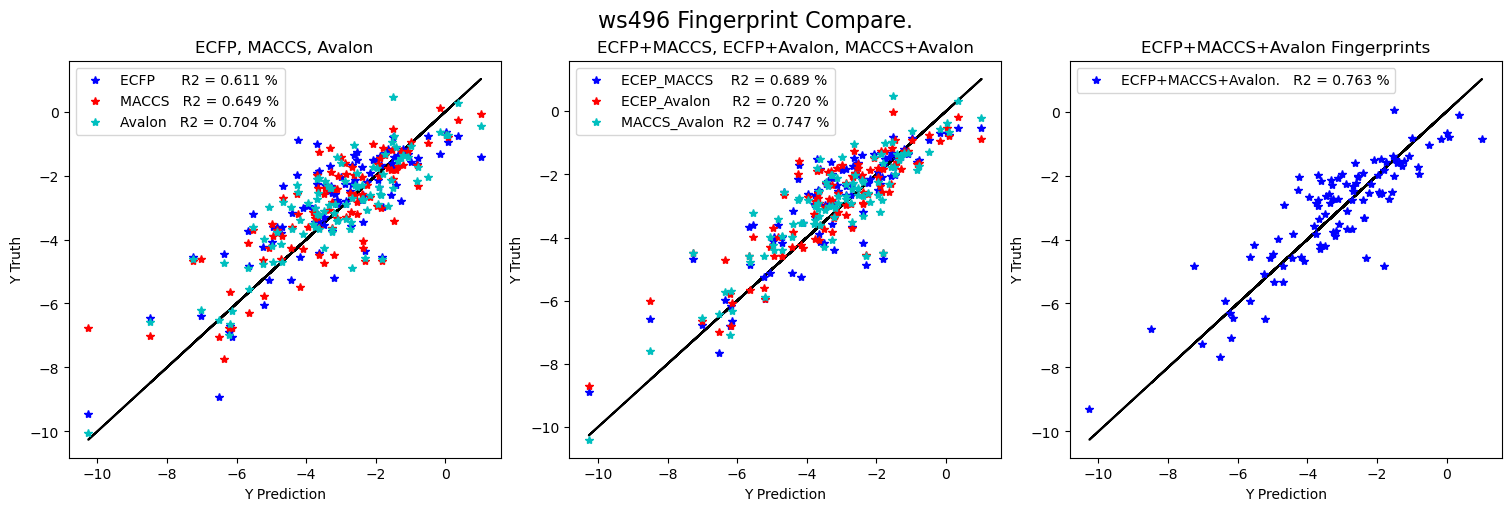

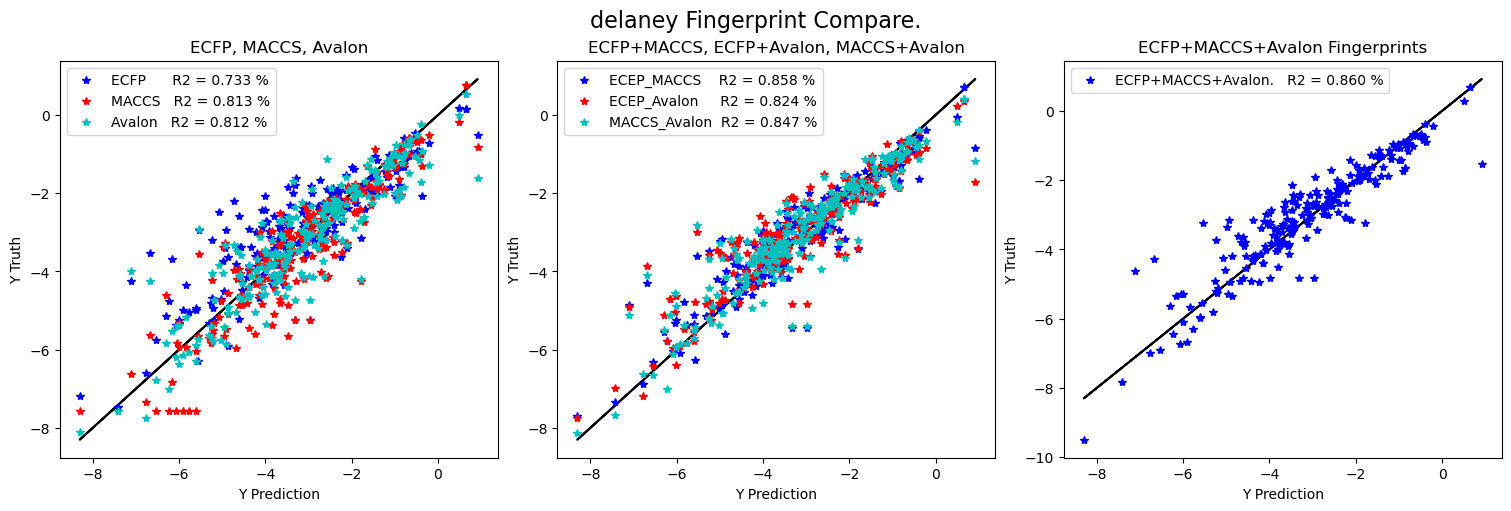

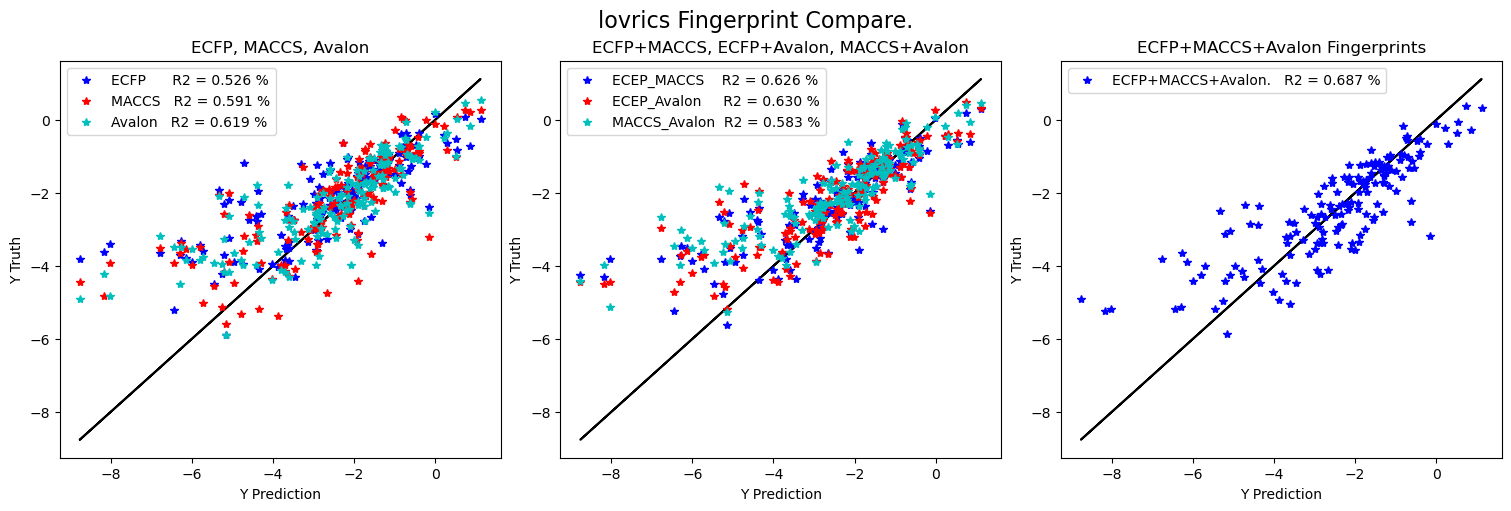

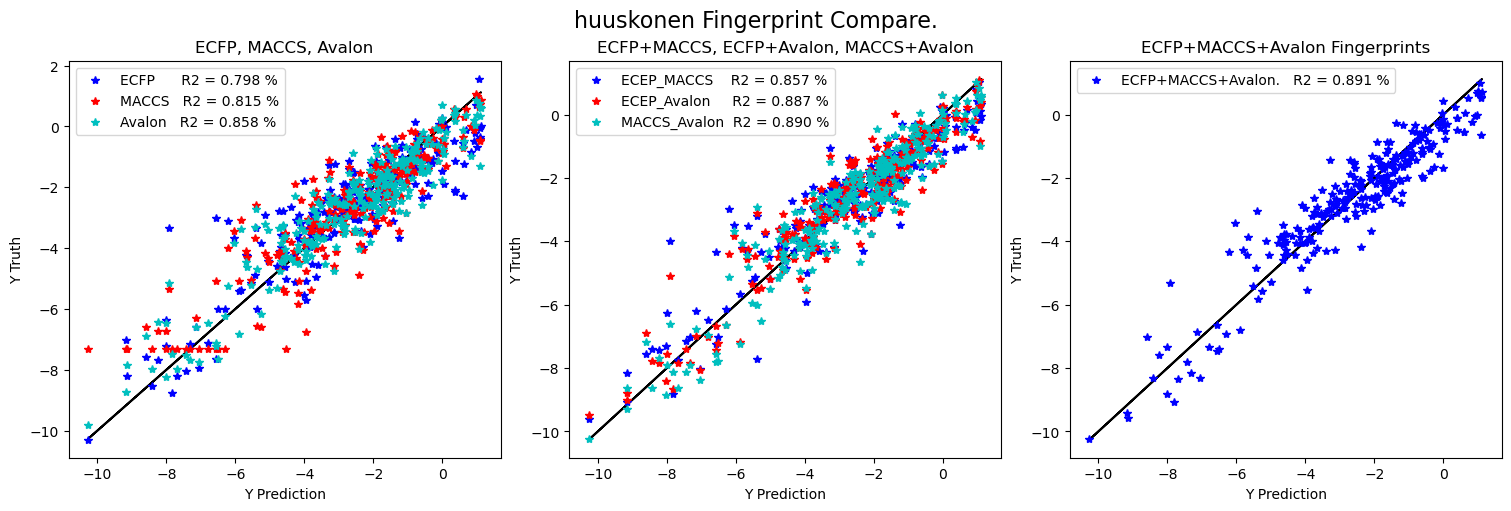

In [39]:
def vis_res_fingerprint(ypre,yte,name,target_path):
    fig = plt.figure(constrained_layout=True, figsize=(15, 5))
    fig.suptitle('{0} Fingerprint Compare.'.format(name), fontsize=16)
    ax0 = fig.add_subplot(131)
    ax0.set_title('ECFP, MACCS, Avalon')
    ax0.plot(yte[0],yte[0],'k-')
    ax0.plot(yte[0],ypre[0],'b*',label='%s R2 = %.3f %%' % ('ECFP     ',r2_score(yte[0],ypre[0])))
    ax0.plot(yte[1],ypre[1],'r*',label='%s R2 = %.3f %%' % ('MACCS  ',r2_score(yte[1],ypre[1])))
    ax0.plot(yte[2],ypre[2],'c*',label='%s R2 = %.3f %%' % ('Avalon  ',r2_score(yte[2],ypre[2])))
    ax0.legend(loc='upper left')
    ax0.set_ylabel('Y Truth')
    ax0.set_xlabel('Y Prediction')
    
    ax1 = fig.add_subplot(132)
    ax1.set_title('ECFP+MACCS, ECFP+Avalon, MACCS+Avalon')
    ax1.plot(yte[0],yte[0],'k-')
    ax1.plot(yte[3],ypre[3],'b*',label='%s R2 = %.3f %%' % ('ECEP_MACCS   ',r2_score(yte[3],ypre[3])))
    ax1.plot(yte[4],ypre[4],'r*',label='%s R2 = %.3f %%' % ('ECEP_Avalon    ',r2_score(yte[4],ypre[4])))
    ax1.plot(yte[5],ypre[5],'c*',label='%s R2 = %.3f %%' % ('MACCS_Avalon ',r2_score(yte[5],ypre[5])))
    ax1.legend(loc='upper left')
    ax1.set_ylabel('Y Truth')
    ax1.set_xlabel('Y Prediction')
    
    ax2 = fig.add_subplot(133)
    ax2.set_title('ECFP+MACCS+Avalon Fingerprints')
    ax2.plot(yte[0],yte[0],'k-')
    ax2.plot(yte[6],ypre[6],'b*',label='%s R2 = %.3f %%' % ('ECFP+MACCS+Avalon.  ',r2_score(yte[6],ypre[6])))
    ax2.legend(loc='upper left')
    ax2.set_ylabel('Y Truth')
    ax2.set_xlabel('Y Prediction')
    plt.show()
    fig.savefig(f"{target_path}/fingerprint_compare_{name}.png", dpi=300)
vis_res_fingerprint(ypred_ws,yte_ws,'ws496',target_path)
vis_res_fingerprint(ypred_de,yte_de,'delaney',target_path)
vis_res_fingerprint(ypred_lo,yte_lo,'lovrics',target_path)
vis_res_fingerprint(ypred_hu,yte_hu,'huuskonen',target_path)